## 002 Model with Data Augmentation

In [2]:
import sys
sys.path.append('../')
sys.path.append('../../../')
# keras expects data to be encoded in a particular way, to_categorical does this encoding for us (one-hot encoding)
from keras.utils.np_utils import to_categorical
import libs.importing as importing
import pandas as pd
import os
import libs.render as render
import libs.cnn_models as cnn_models
import libs.analysis as analysis
import libs.normalization as normalization
from importlib import reload
import libs.data_prep as data_prep
import numpy as np

from pylab import rcParams
rcParams['figure.figsize'] = (10,8)

In [3]:
# LOAD PATCH DATA REFERENCES

# directory setup
data_source = '../4b7ab9e9'
train_dir = os.path.join(data_source, 'train')
test_dir = os.path.join(data_source, 'test')
val_dir = os.path.join(data_source, 'val')

# get references to the data we want
train_patches_df = pd.read_csv(os.path.join(train_dir, 'patches_cleaned_shuffled.csv'))
train_data_reader = importing.PatchDataReader(os.path.join(train_dir, 'patches'), train_patches_df)

test_patches_df = pd.read_csv(os.path.join(test_dir, 'patches_cleaned_shuffled.csv'))
test_data_reader = importing.PatchDataReader(os.path.join(test_dir, 'patches'), test_patches_df)

val_patches_df = pd.read_csv(os.path.join(val_dir, 'patches_cleaned_shuffled.csv'))
val_data_reader = importing.PatchDataReader(os.path.join(val_dir, 'patches'), val_patches_df)

In [4]:
## READ PATCH DATA

# load train, test, and validation data
x_train, y_train = train_data_reader.read_data()
x_test, y_test = test_data_reader.read_data()
x_val, y_val = val_data_reader.read_data()

# LOG RESULTS
## Visualize the patches
data_prep.log_patch_data_reader(train_dir, train_data_reader)
data_prep.log_patch_data_reader(test_dir, test_data_reader)
data_prep.log_patch_data_reader(val_dir, val_data_reader)

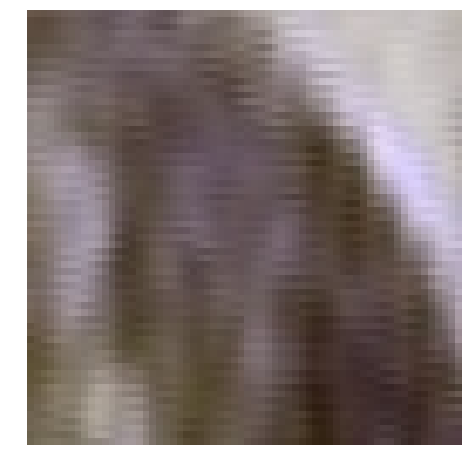

3


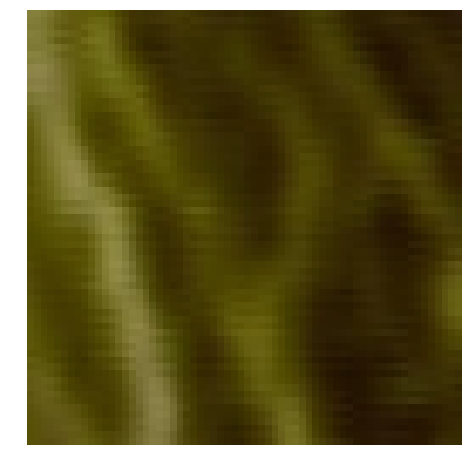

1


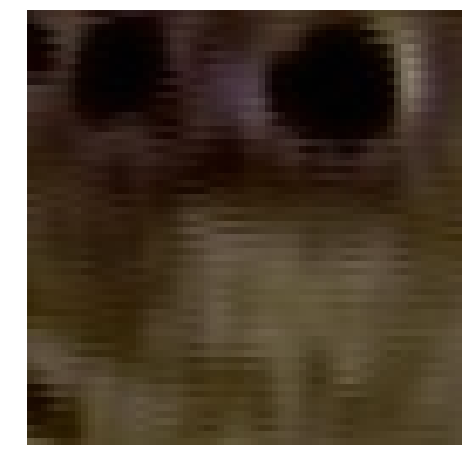

2


In [5]:
# INSPECT : look at class 1 = benign and 2 = papilloma, 3 = dysplasia+carcinoma

render.plot_image(x_train[0])
print(y_train[0])

render.plot_image(x_train[2])
print(y_train[2])

render.plot_image(x_train[8])
print(y_train[8])


In [6]:
## CONVERT CLASSES TO KERAS FORMAT
# keras expects classes to be number from 0-N, we are using 1-N numbering so we need to convert.
# then we also have to change the classes to one-hot encoding

y_train_oh = to_categorical(y_train - 1)
y_test_oh  = to_categorical(y_test - 1)
y_val_oh   = to_categorical(y_val - 1)

In [7]:
# NORMALIZATION

m, std = normalization.dataset_mean_and_std(x_train)

x_train = (x_train - m) / std
x_test  = (x_test - m) / std
x_val   = (x_val - m) / std

In [8]:
## MODEL : load from file, show summary, and compile
reload(cnn_models)

model = cnn_models.model_simple_v2_3class_dropout()
display(model.summary())

# parameters:
learning_rate = 1e-4

model.compile(optimizer = 'adam', loss = "categorical_crossentropy", metrics=["accuracy"])


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 64, 64, 32)        896       
_________________________________________________________________
activation_1 (Activation)    (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 64, 64, 32)        9248      
_________________________________________________________________
activation_2 (Activation)    (None, 64, 64, 32)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 32, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 32, 32, 64)        18496     
__________

None

In [9]:
data_prep.check_for_nans(x_train)
data_prep.check_for_nans(x_test)
data_prep.check_for_nans(x_val)

print(y_train[:100], y_test[:100], y_val[:100])

[3 3 1 3 3 3 1 2 2 3 3 3 3 1 3 3 3 3 3 3 1 3 3 3 3 1 3 3 3 3 1 3 3 2 3 3 3
 3 1 3 2 1 3 1 3 3 1 2 1 3 3 2 3 3 1 3 2 3 3 3 3 3 3 3 3 2 3 3 3 3 2 3 3 2
 3 3 1 3 3 3 3 3 3 3 3 3 3 3 3 2 1 2 3 3 2 3 3 3 3 3] [1 3 2 1 2 3 1 3 1 3 3 3 3 3 3 3 3 1 1 3 1 2 3 3 1 3 3 3 1 3 3 1 3 1 3 1 3
 3 1 1 2 3 3 1 3 3 3 3 1 1 3 3 3 1 1 3 1 3 1 1 3 1 1 2 3 1 1 3 3 3 2 1 1 2
 3 3 3 3 3 1 3 1 1 3 3 3 3 1 3 1 1 1 1 3 3 3 3 1 1 3] [1 2 1 1 1 3 3 2 1 1 1 2 2 3 3 1 3 2 1 1 1 3 3 3 1 3 1 1 2 2 2 1 1 3 1 1 3
 3 2 3 2 1 2 1 2 2 2 2 3 3 3 2 3 1 2 2 2 1 3 3 1 2 1 1 3 3 2 1 1 3 1 1 1 2
 2 3 1 2 3 3 3 3 3 3 3 2 1 2 2 3 1 2 3 1 1 3 2 1 1 1]


In [10]:
## Now Let's do a run with data augmentation
reload(cnn_models)
from keras.preprocessing.image import ImageDataGenerator

# parameters
epochs = 10
batch_size = 16

datagen = ImageDataGenerator(
        featurewise_center=False,             # set input mean to 0 over the dataset
        samplewise_center=False,              # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,   # divide each input by its std
        zca_whitening=False,                  # apply ZCA whitening
        rotation_range=45,                    # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1,                     # Randomly zoom image 
        width_shift_range=0.1,               # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,              # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,                 # randomly flip images
        vertical_flip=False)                  # randomly flip images


datagen.fit(x_train)


history = model.fit_generator(datagen.flow(x_train,y_train_oh, batch_size=batch_size),
                              epochs = epochs, validation_data = (x_test,y_test_oh),
                              workers = 4,
                              verbose = 1, steps_per_epoch = x_train.shape[0] # batch_size
                              , callbacks=[cnn_models.annealer()])


#history = model.fit(x_train,y_train_oh, batch_size=batch_size,
#                              epochs = epochs,
#                              validation_data = (x_test,y_test_oh), shuffle=True,
#                              verbose = 1, callbacks=[cnn_models.annealer()])

Epoch 1/10
3415/3415 [==============================] - 153s 45ms/step - loss: 0.5638 - acc: 0.8121 - val_loss: 0.4091 - val_acc: 0.9269
Epoch 2/10
3415/3415 [==============================] - 111s 32ms/step - loss: 0.5191 - acc: 0.8237 - val_loss: 0.8310 - val_acc: 0.8073
Epoch 3/10
3415/3415 [==============================] - 111s 32ms/step - loss: 0.6264 - acc: 0.8100 - val_loss: 1.4983 - val_acc: 0.8638
Epoch 4/10
3415/3415 [==============================] - 111s 32ms/step - loss: 0.6678 - acc: 0.8005 - val_loss: 1.1932 - val_acc: 0.6944
Epoch 5/10
3415/3415 [==============================] - 111s 32ms/step - loss: 0.7580 - acc: 0.7885 - val_loss: 1.4049 - val_acc: 0.7375

Epoch 00005: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
Epoch 6/10
3415/3415 [==============================] - 111s 32ms/step - loss: 0.6379 - acc: 0.8040 - val_loss: 0.8296 - val_acc: 0.7508
Epoch 7/10
3415/3415 [==============================] - 111s 32ms/step - loss: 0.6666 - acc: 0.80

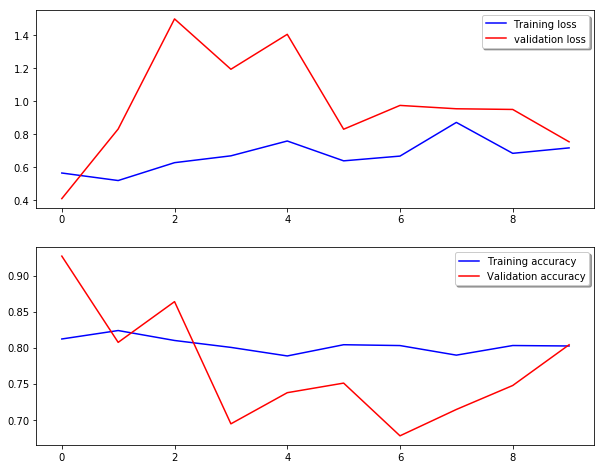

Precision (specificity): 81.974%
Recall (sensitivity): 66.269%
Accuracy: 71.587%
F1: 60.975%


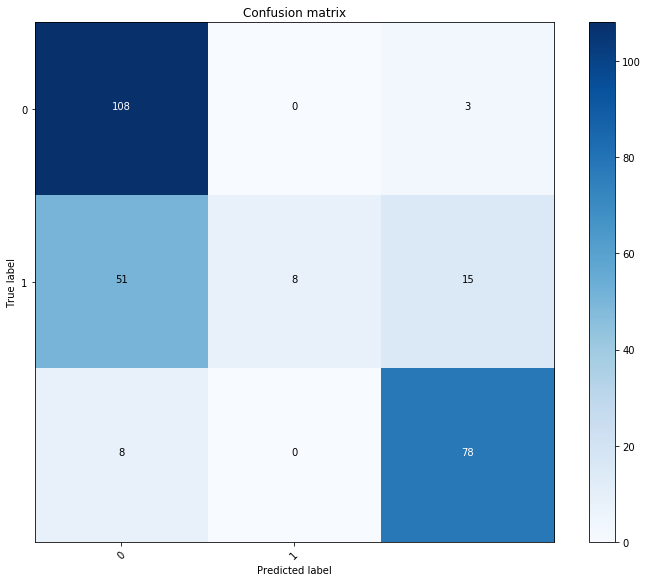

In [11]:
render.plot_training_and_validation_curves(history)
y_pred_oh = model.predict(x_val)

cm = render.setup_confusion_matrix(y_pred_oh, x_val, y_val_oh)

render.plot_confusion_matrix(cm, num_classes=2)

scores = analysis.get_scores_oh(y_val_oh, y_pred_oh)
analysis.print_scores(scores)

In [12]:
## CONTOUR LEVEL ANALYSIS
reload(analysis)

analysis.plot_contour_predictions(test_data_reader, model, test_dir, norm_data=(m, std))
analysis.contour_statistics(test_data_reader, model, test_dir, norm_data=(m, std))

hgv-2cdb69f6 [0.30248207 0.12479629 0.57272166] 1
mdi-461bdebc [0.6697493  0.11344786 0.21680264] 0
mdi-5e3d3832 [0.6741827  0.11252591 0.2132916 ] 0
mdi-461bdebc [0.35636136 0.13398568 0.50965285] 2
hgv-2cdb69f6 [0.14041422 0.32473388 0.53485185] 1
mdi-9ce9698b [0.12994315 0.04744741 0.8226094 ] 2


In [13]:
model.save('model_003_dataaug.h5')